In [1]:
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, HTML

%matplotlib inline

# Machine Learning con Python3 y Scikit-learn

## Carga de los datos

Para cargar los datos que usaremos en esta sesión, utilizaremos la librería [Pandas](http://pandas.pydata.org/):

In [2]:
import pandas as pd

Todas las funciones de pandas llevarán el prefijo `pd.`:

In [3]:
pd.Series([4, 1, 7, 8, 7, 8, 3, 9, 7, 1])

0    4
1    1
2    7
3    8
4    7
5    8
6    3
7    9
8    7
9    1
dtype: int64

Cargar datos con Pandas es fácil:

In [4]:
movies = pd.read_csv('data/movies.csv')

En este caso cargamos un set de datos de películas de [MovieLens](http://grouplens.org/datasets/movielens/) en formato [CSV](https://es.wikipedia.org/wiki/CSV).

Con Pandas podemos leer y escribir en una [amplia variedad de formatos](http://pandas.pydata.org/pandas-docs/stable/io.html), entre los cuales se destacan: CSV, Excel, HDF, SQL, JSON y HTML.

Un aspecto interesante es que se pueden cargar datos desde cualquier página web:

In [5]:
pd.read_csv('https://goo.gl/7uwQAO', index_col=0).head()

,time,co2
1,1959.000000,315.42
2,1959.083333,316.31
3,1959.166667,316.50
4,1959.250000,317.56
5,1959.333333,318.13


En la celda anterior se usó el argumento `index_col=0` para indicar que la primera columna de datos debe ser usada como índice. Y luego se ejecutó el método `head()` de la tabla, para mostrar sólo los primeros datos.

Pandas es una herramienta de exploración muy potente. En la siguiente celda se cargan desde una página externa los promedios globales de concentración de CO2, con periodicidad mensual, entre los años 1980 y 2016. Luego se muestra una descripción estadística de los datos y su gráfico. ¡Todo esto en tan sólo tres lineas de código!

count    436.000000
mean     366.701307
std       18.271568
min      336.950000
25%      351.795000
50%      364.595000
75%      382.327500
max      404.080000
Name: Average, dtype: float64

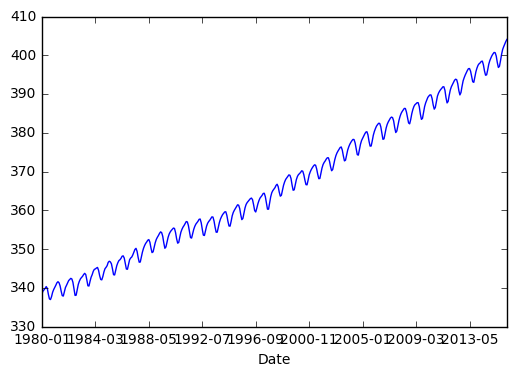

In [6]:
co2 = pd.read_csv('https://goo.gl/6zEEEf', index_col=0)['Average']
display(co2.describe())
co2.plot();

Ahora carguemos el resto de los datos que utilizaremos en esta sesión (la tabla `movies` ya la cargamos más arriba):

In [7]:
links = pd.read_csv('data/links.csv')
ratings = pd.read_csv('data/ratings.csv')
tags = pd.read_csv('data/tags.csv')

Para acceder secuencialmente a las tablas de datos, las agregaremos a un diccionario:

In [8]:
tables = {
    'links':   links,
    'movies':  movies,
    'ratings': ratings,
    'tags':    tags,
}

## Exploración de los datos

Actualmente no sabemos nada de los datos, imprimamos un par de filas de cada tabla:

In [9]:
for name, table in tables.items():
    display(HTML('<h3>{}</h3>'.format(name)), table.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1138537770
1,15,1955,dentist,1193435061
2,15,7478,Cambodia,1170560997
3,15,32892,Russian,1170626366
4,15,34162,forgettable,1141391765


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


La siguiente celda (que no es muy simple de entender y no está muy limpia) calcula las evaluaciones promedio por película. Si tenemos tiempo podemos ahondar más en este código.

In [10]:
m = ratings[['rating', 'movieId']].groupby('movieId', as_index=False).aggregate(np.mean)
pd.merge(m, movies[['title', 'movieId']]).set_index('movieId').sort_values('rating', ascending=False).head()

,rating,title
movieId,,
163949,5.0,The Beatles: Eight Days a Week - The Touring Y...
71180,5.0,Padre padrone (1977)
51471,5.0,Amazing Grace (2006)
52617,5.0,Woman on the Beach (Haebyeonui yeoin) (2006)
53887,5.0,O Lucky Man! (1973)


¿Cuales son los posibles valores de las puntuaciones?

In [11]:
r = ratings.rating.unique()
r.sort()
r

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ])

¿Cómo se distribuyen las evaluaciones?

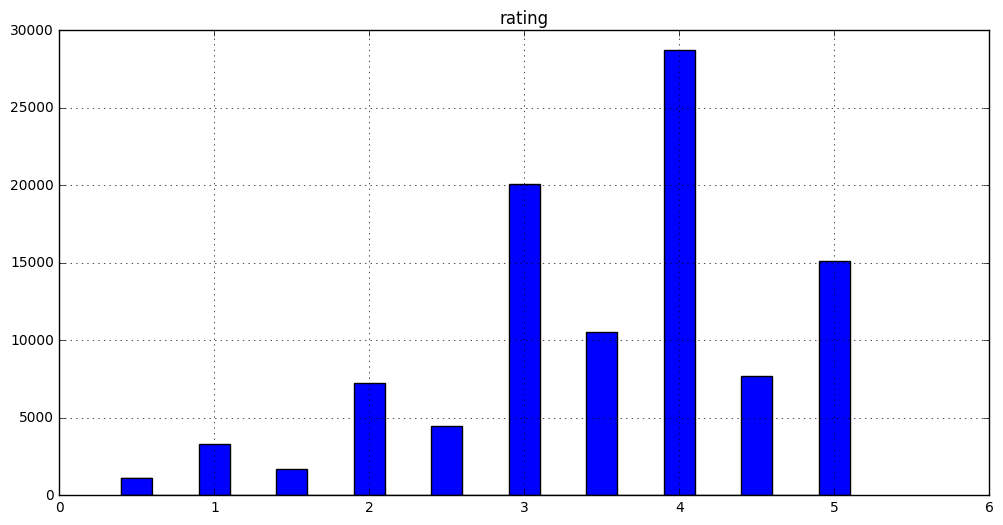

In [12]:
ratings.hist(
    'rating',
    figsize=(12,6),
    bins=[
        0.4, 0.6,
        0.9, 1.1,
        1.4, 1.6,
        1.9, 2.1, 
        2.4, 2.6,
        2.9, 3.1,
        3.4, 3.6,
        3.9, 4.1,
        4.4, 4.6, 
        4.9, 5.1
    ]
);

¿Cuales son los posibles valores de los géneros?

In [13]:
movies.genres.unique()[:10]

array(['Adventure|Animation|Children|Comedy|Fantasy',
       'Adventure|Children|Fantasy', 'Comedy|Romance',
       'Comedy|Drama|Romance', 'Comedy', 'Action|Crime|Thriller',
       'Adventure|Children', 'Action', 'Action|Adventure|Thriller',
       'Comedy|Horror'], dtype=object)

## Limpiando datos

Los géneros en la forma `'Adventure|Animation|Children|Comedy|Fantasy'` no sirven de mucho. Vamos a estandarizarlos y separarlos.

Primero vamos a agregar una nueva columna con los generos en minúsculas:

In [14]:
movies['genres_lower'] = movies.genres.apply(lambda s: s.lower())
movies.head()

,movieId,title,genres,genres_lower
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,adventure|animation|children|comedy|fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy,adventure|children|fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance,comedy|romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,comedy|drama|romance
4,5,Father of the Bride Part II (1995),Comedy,comedy


Luego eliminamos la antigua columna de géneros:

In [15]:
del movies['genres']
movies.head()

,movieId,title,genres_lower
0,1,Toy Story (1995),adventure|animation|children|comedy|fantasy
1,2,Jumanji (1995),adventure|children|fantasy
2,3,Grumpier Old Men (1995),comedy|romance
3,4,Waiting to Exhale (1995),comedy|drama|romance
4,5,Father of the Bride Part II (1995),comedy


En la siguiente celda agregamos cáda género a un set. Esto nos garantiza que no pueden haber géneros duplicados dentro del set.

In [16]:
genres = set()
for s in movies.genres_lower.unique():
    for g in s.split('|'):
        genres.add(g)

¿Cuantos y cuales géneros hay?

In [17]:
display(len(genres), genres)

20

{'(no genres listed)',
 'action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'film-noir',
 'horror',
 'imax',
 'musical',
 'mystery',
 'romance',
 'sci-fi',
 'thriller',
 'war',
 'western'}

Para cada género vamos a agregar una nueva columna. Cuando una pelicula tenga ese género, su fila será un 1. Será un 0 en caso contrario.

In [18]:
for g in genres:
    movies[g] = movies.genres_lower.str.contains(g).apply(lambda b: int(b))

movies.head()

/home/cganterh/Git/machine_learning_workshop/env/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


,movieId,title,genres_lower,mystery,film-noir,crime,thriller,imax,war,adventure,...,action,romance,western,children,(no genres listed),sci-fi,musical,comedy,drama,horror
0,1,Toy Story (1995),adventure|animation|children|comedy|fantasy,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
1,2,Jumanji (1995),adventure|children|fantasy,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),comedy|romance,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,4,Waiting to Exhale (1995),comedy|drama|romance,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
4,5,Father of the Bride Part II (1995),comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Por fin ML!

Saber qué algoritmo usar en determinados casos es un arte y requiere bastante conocimiento sobre el problema y los datos.

![](http://scikit-learn.org/stable/_static/ml_map.png)
Fuente: <http://scikit-learn.org/stable/tutorial/machine_learning_map/>

Primero probaremos el algoritmo de clustering KMeans. KMeans funciona en dos pasos:

1.  cada muestra se asocia al centroide más cercano
2.  cada centroide se ajusta para ubicarlo en el centro de sus puntos asociados

Estos dos pasos se repiten hasta que la posición de los centroides deje de cambiar. (Hay que conocer cuantos clusters hay. Los centroides pueden partir en posiciones aleatorias.)

La siguiente figura muestra una animación de los pasos de KMeans para un problema en 2 dimensiones:

![](http://simplystatistics.org/wp-content/uploads/2014/02/kmeans.gif)
Fuente: <http://simplystatistics.org/2014/02/18/k-means-clustering-in-a-gif/>

Primero importemos KMeans desde sklearn.

In [19]:
from sklearn.cluster import KMeans

Intentemos aplicar KMeans para ver si hay grupos de peliculas similares. Para esto utilizaremos los datos de género que limpiamos antes.

Seleccionemos primero las columnas que queremos utilizar:

In [20]:
features = ['action', 'adventure', 'animation', 'children', 'comedy',
            'crime', 'documentary', 'drama', 'fantasy', 'film-noir',
            'horror', 'imax', 'musical', 'mystery', 'romance', 'sci-fi',
            'thriller', 'war', 'western']

movie_features = movies[features]
movie_features.head()

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Ya tenemos los datos sobre los cuales queremos aplicar KMeans, pero no sabemos cuantos clusters hay. Para determinarlo podemos graficar el score (distancias negativas) para diferente cantidad de clusters. (<https://algobeans.com/2015/11/30/k-means-clustering-laymans-tutorial/>)

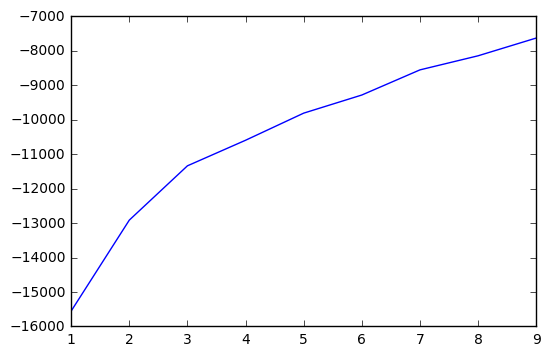

In [21]:
clusters = range(1, 10)
scores = [
    KMeans(n).fit(movie_features).score(movie_features)
    for n in clusters
]
plt.plot(clusters, scores);

Podemos notar que hay un quiebre en el crecimiento del score, entre 3 y 4 clusters.

Agreguemos una columna a la tabla de peliculas indicando a qué cluster pertenecen (4 clusters):

In [22]:
movies['cluster'] = KMeans(4).fit_predict(movies[features])

Tienen sentido los clusters que creamos?

In [23]:
for i in range(4):
    display(movies[['title', 'genres_lower']][movies.cluster == i].head())

,title,genres_lower
5,Heat (1995),action|crime|thriller
9,GoldenEye (1995),action|adventure|thriller
19,Money Train (1995),action|comedy|crime|drama|thriller
20,Get Shorty (1995),comedy|crime|thriller
21,Copycat (1995),crime|drama|horror|mystery|thriller


,title,genres_lower
0,Toy Story (1995),adventure|animation|children|comedy|fantasy
2,Grumpier Old Men (1995),comedy|romance
3,Waiting to Exhale (1995),comedy|drama|romance
4,Father of the Bride Part II (1995),comedy
6,Sabrina (1995),comedy|romance


,title,genres_lower
13,Nixon (1995),drama
15,Casino (1995),crime|drama
16,Sense and Sensibility (1995),drama|romance
23,Powder (1995),drama|sci-fi
24,Leaving Las Vegas (1995),drama|romance


,title,genres_lower
1,Jumanji (1995),adventure|children|fantasy
7,Tom and Huck (1995),adventure|children
8,Sudden Death (1995),action
12,Balto (1995),adventure|animation|children
14,Cutthroat Island (1995),action|adventure|romance
